## Онлайн-магазин

In [1]:
import pandas as pd
import numpy as np

import pingouin as pg
import scipy.stats as ss
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from scipy.stats import bootstrap

import lifelines as lf

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
users = pd.read_csv("ab_users_data.csv")
products = pd.read_csv("ab_products.csv")
orders = pd.read_csv("ab_orders.csv")

In [45]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [46]:
users.shape

(4337, 6)

In [13]:
a = users['user_id'].nunique()
b = users.query('group == 0')['user_id'].nunique()
c = users.query('group == 1')['user_id'].nunique()
d = users.shape[0]
e = users['action'].value_counts()[0]
f = users['action'].value_counts()[1]
print('Всего действий =', d)
print('Созданных заказов =', e)
print('Отмененных заказов =', f)
print('Всего пользователей =', a)
print('Пользователи контрольной группы =', b)
print('Пользователи тестовой группы =', c)

Всего действий = 4337
Созданных заказов = 4123
Отмененных заказов = 214
Всего пользователей = 1017
Пользователи контрольной группы = 515
Пользователи тестовой группы = 502


C:\Users\Алмас\AppData\Local\Temp\ipykernel_17088\2168221501.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  e = users['action'].value_counts()[0]
C:\Users\Алмас\AppData\Local\Temp\ipykernel_17088\2168221501.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = users['action'].value_counts()[1]


In [38]:
gr_01 = set(users.query('group==0').user_id)
gr_11 = set(users.query('group==1').user_id)

gr_01.intersection(gr_11)

set()

_Множества не пересекаются_ - пользователи из контрольной группы не могут быть частью тестовой группы - __Независимые выборки__

In [4]:
canc_orders = users.query("action == 'cancel_order'").order_id #заказы, которые отменили
canc_orders

8        1258
39       1296
47       1298
54       1308
60       1315
        ...  
4221    54938
4255    56612
4259    56772
4307    58492
4321    59055
Name: order_id, Length: 214, dtype: int64

In [5]:
users["is_canceled"] = users["order_id"].isin(canc_orders).astype(int) #делаем переменную отмены заказа
users.head()

,user_id,order_id,action,time,date,group,is_canceled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,0
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,1
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,0


## Гипотеза 1: Изменилась пропорция заказов (созданных и отмененных заказов)

__Анализ различий в отмененных заказов__

In [6]:
canceled_crosstab = pd.crosstab(users.group, users.is_canceled)
canceled_crosstab

is_canceled,0,1
group,,
0,1527,164
1,2382,264


In [7]:
chi2, p, dof, expected = chi2_contingency(canceled_crosstab)
print(f"χ²: {chi2}, p-значение: {p}")

χ²: 0.061601349659573534, p-значение: 0.8039826126366771


In [8]:
exp, obs, stats = pg.chi2_independence(data=users, x="group", y="is_canceled")
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.061601,1.0,0.803983,0.003769,0.057086
1,cressie-read,0.666667,0.061633,1.0,0.803933,0.003770,0.057090
2,log-likelihood,0.000000,0.061697,1.0,0.803834,0.003772,0.057097
3,freeman-tukey,-0.500000,0.061745,1.0,0.803759,0.003773,0.057103
4,mod-log-likelihood,-1.000000,0.061794,1.0,0.803683,0.003775,0.057109
5,neyman,-2.000000,0.061892,1.0,0.803530,0.003778,0.057120


__Анализ различий в совершенных и отмененных заказов__

In [9]:
actions_crosstab = pd.crosstab(users['group'], users['action'])
actions_crosstab

action,cancel_order,create_order
group,,
0,82,1609
1,132,2514


In [10]:
exp, obs, stats = pg.chi2_independence(data=users, x="group", y="action")
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.018211,1.0,0.892652,0.002049,0.052089
1,cressie-read,0.666667,0.018219,1.0,0.892629,0.002050,0.052090
2,log-likelihood,0.000000,0.018235,1.0,0.892583,0.002050,0.052091
3,freeman-tukey,-0.500000,0.018247,1.0,0.892548,0.002051,0.052093
4,mod-log-likelihood,-1.000000,0.018259,1.0,0.892513,0.002052,0.052094
5,neyman,-2.000000,0.018283,1.0,0.892442,0.002053,0.052097


In [11]:
chi2, p, dof, expected = chi2_contingency(actions_crosstab)
print(f"χ²: {chi2}, p-значение: {p}")

χ²: 0.018211165651942023, p-значение: 0.8926523935841298


__Анализ различий во всех заказах__

In [36]:
actions_crosstab_copy=actions_crosstab.copy()
actions_crosstab_copy['all_order'] = actions_crosstab_copy['cancel_order'] + actions_crosstab_copy['create_order']
actions_crosstab_copy

action,cancel_order,create_order,all_order
group,,,
0,82,1609,1691
1,132,2514,2646


In [37]:
chi2, p, dof, expected = chi2_contingency(actions_crosstab_copy)
print(f"χ²: {chi2}, p-значение: {p}")

χ²: 0.04277579068025318, p-значение: 0.9788392037546264


__Пропорции созданных, совершенных и отмененных заказов статистически значимо не изменились__

## Гипотеза 2: Изменилось число заказов на пользователя

In [12]:
users_1 = users.query("action == 'create_order'")[['user_id', 'order_id', 'action', 'time', 'date',	'group']]	
users_1

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


In [56]:
users_1['user_id'].value_counts()

user_id
1170    13
1533    13
1641    13
1583    12
1537    12
        ..
1395     1
1853     1
1385     1
1381     1
1472     1
Name: count, Length: 1017, dtype: int64

In [13]:
ord_per_user = users_1.groupby(["group", "user_id"], as_index=False).size()
ord_per_user
# Подсчитали количество заказов на каждого пользователя с помощью метода .size()

,group,user_id,size
0,0,964,2
1,0,966,1
2,0,968,3
3,0,969,2
4,0,972,1
...,...,...,...
1012,1,1976,5
1013,1,1977,4
1014,1,1978,7
1015,1,1979,6


In [74]:
ord_per_user.query('group == 0')['size'].describe()

count    515.000000
mean       3.124272
std        1.922651
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       13.000000
Name: size, dtype: float64

In [75]:
ord_per_user.query('group == 1')['size'].describe()

count    502.000000
mean       5.007968
std        2.210467
min        1.000000
25%        4.000000
50%        5.000000
75%        6.000000
max       13.000000
Name: size, dtype: float64

<Axes: xlabel='size', ylabel='count'>

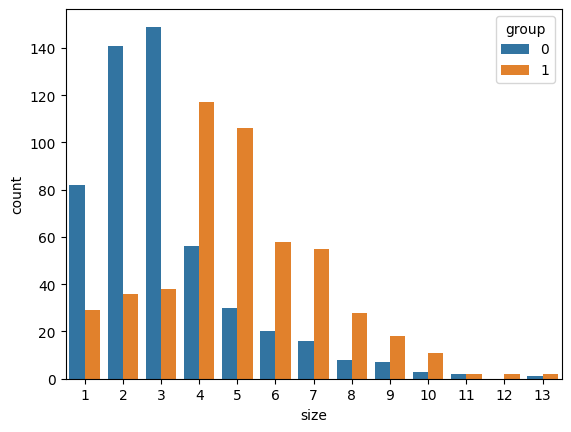

In [60]:
sns.countplot(data=ord_per_user, x="size", hue="group")

In [66]:
pg.ttest(x=ord_per_user.query("group==0")["size"], 
         y=ord_per_user.query("group==1")["size"])
# В среднем пользователи из тестовой группы делают на ~ 2 заказа больше чем пользователи из контрольной группы

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-14.485157,988.435475,two-sided,2.907783e-43,"[-2.14, -1.63]",0.910119,7.663e+39,1.0


In [77]:
pg.mwu(x=ord_per_user.query("group==0")["size"], 
         y=ord_per_user.query("group==1")["size"])
#Манн-Уитни показывает, что при схожих распределениях, тест показывает какова вероятность, что  случайно взятые данные из первой группы (контрольной) будут больше данные из второй 
# CLES = 0.24 - 24% вероятности (меньше 50% - незначимл)

,U-val,alternative,p-val,RBC,CLES
MWU,61172.5,two-sided,6.987140e-49,0.526767,0.236617


__Число заказов на пользователя увеличилось статистически значимо__:\
_В среднем пользователи из тестовой группы делают на ~ 2 заказа больше чем пользователи из контрольной группы_

## Гипотеза 3: Изменилась стоимость заказа

In [14]:
user_order = users_1[["user_id", "order_id", "group"]].merge(orders)
user_order

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,1,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,967,1259,1,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
...,...,...,...,...,...
4118,990,59422,1,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4119,1418,59439,1,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4120,1605,59464,0,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4121,1461,59487,0,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [15]:
user_order['product_ids'] = user_order['product_ids'].str.replace('{','').str.replace('}','').str.split(',')
user_order['product_ids']

0          [75,  22,  53,  84]
1               [56,  76,  39]
2          [76,  34,  41,  38]
3                     [74,  6]
4          [20,  45,  67,  26]
                 ...          
4118             [84,  8,  24]
4119    [9,  25,  75,  30,  6]
4120            [60,  41,  46]
4121             [9,  62,  77]
4122                 [17,  85]
Name: product_ids, Length: 4123, dtype: object

In [16]:
user_orders = user_order.explode("product_ids")
user_orders

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,75
0,964,1255,0,2022-08-26 00:00:19.000000,22
0,964,1255,0,2022-08-26 00:00:19.000000,53
0,964,1255,0,2022-08-26 00:00:19.000000,84
1,965,1256,1,2022-08-26 00:02:21.000000,56
...,...,...,...,...,...
4121,1461,59487,0,2022-09-08 23:29:06.000000,9
4121,1461,59487,0,2022-09-08 23:29:06.000000,62
4121,1461,59487,0,2022-09-08 23:29:06.000000,77
4122,1376,59533,0,2022-09-08 23:41:24.000000,17


In [17]:
user_orders['product_ids'] = user_orders['product_ids'].astype('int64')

In [18]:
df = user_orders.merge(products, left_on = 'product_ids', right_on = 'product_id', how = 'left')
df

,user_id,order_id,group,creation_time,product_ids,product_id,name,price
0,964,1255,0,2022-08-26 00:00:19.000000,75,75,сок ананасовый,120.0
1,964,1255,0,2022-08-26 00:00:19.000000,22,22,сок мультифрукт,120.0
2,964,1255,0,2022-08-26 00:00:19.000000,53,53,мука,78.3
3,964,1255,0,2022-08-26 00:00:19.000000,84,84,мандарины,90.4
4,965,1256,1,2022-08-26 00:02:21.000000,56,56,сосиски,150.0
...,...,...,...,...,...,...,...,...
13821,1461,59487,0,2022-09-08 23:29:06.000000,9,9,чай черный листовой,83.5
13822,1461,59487,0,2022-09-08 23:29:06.000000,62,62,сок яблочный,120.0
13823,1461,59487,0,2022-09-08 23:29:06.000000,77,77,курица,298.4
13824,1376,59533,0,2022-09-08 23:41:24.000000,17,17,морс брусничный,190.0


In [19]:
df_1 = df[['user_id', 'order_id', 'group', 'creation_time', 'price']]
df_1

,user_id,order_id,group,creation_time,price
0,964,1255,0,2022-08-26 00:00:19.000000,120.0
1,964,1255,0,2022-08-26 00:00:19.000000,120.0
2,964,1255,0,2022-08-26 00:00:19.000000,78.3
3,964,1255,0,2022-08-26 00:00:19.000000,90.4
4,965,1256,1,2022-08-26 00:02:21.000000,150.0
...,...,...,...,...,...
13821,1461,59487,0,2022-09-08 23:29:06.000000,83.5
13822,1461,59487,0,2022-09-08 23:29:06.000000,120.0
13823,1461,59487,0,2022-09-08 23:29:06.000000,298.4
13824,1376,59533,0,2022-09-08 23:41:24.000000,190.0


In [88]:
value_per_order = df_1.groupby(["group", "order_id"], as_index=False).price.sum()
value_per_order

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1258,85.0
3,0,1261,430.7
4,0,1262,358.6
...,...,...,...
4118,1,59220,264.2
4119,1,59250,150.3
4120,1,59390,620.8
4121,1,59422,241.2


__Распределение данных__

<Axes: xlabel='price', ylabel='Count'>

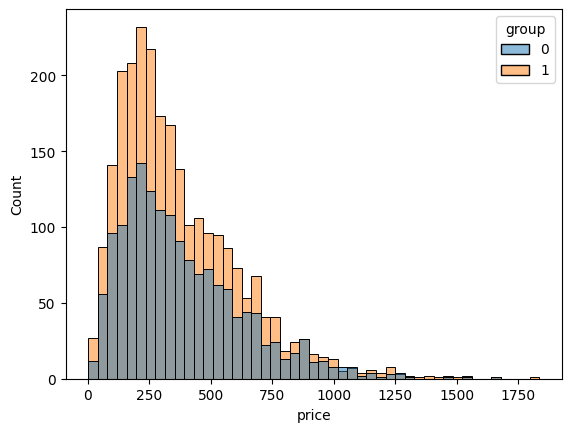

In [89]:
sns.histplot(data=value_per_order, x="price", hue="group")

<Axes: xlabel='group', ylabel='price'>

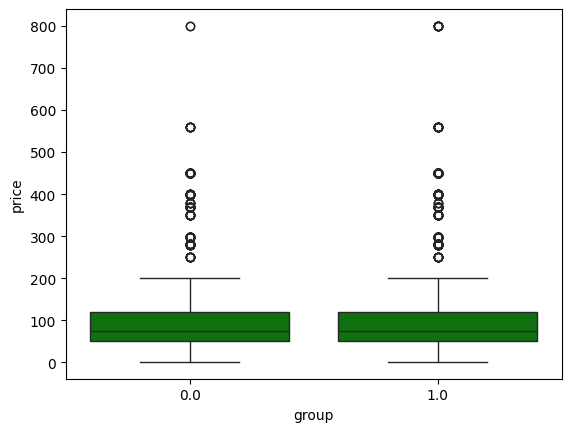

In [97]:
sns.boxplot(x=value_per_order.group, y=df_1.price, color='green')

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

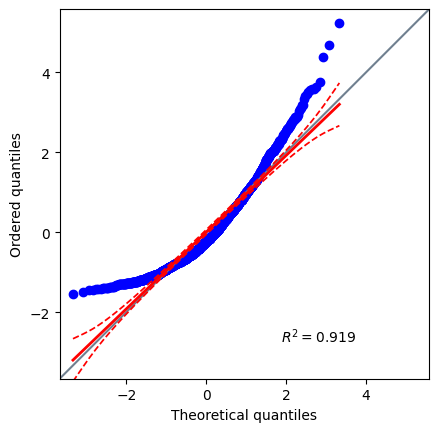

In [98]:
pg.qqplot(value_per_order.query("group == 0").price)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

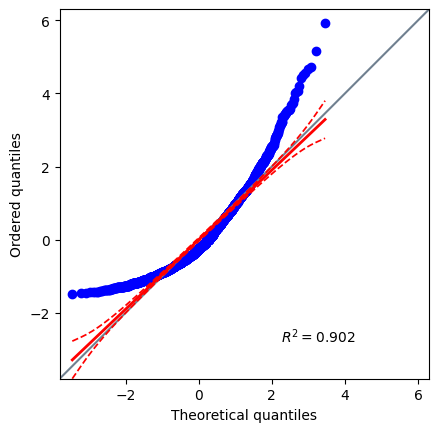

In [99]:
pg.qqplot(value_per_order.query("group == 1").price)

__Проверка распределения на нормальность__

In [108]:
pg.normality(data=value_per_order, dv= "price", group="group", method="normaltest")

,W,pval,normal
group,,,
0,288.620818,2.122197e-63,False
1,597.683192,1.639623e-130,False


In [109]:
ss.normaltest(value_per_order.query('group == 0')['price'])

NormaltestResult(statistic=288.6208180681972, pvalue=2.122196897492167e-63)

In [110]:
ss.normaltest(value_per_order.query('group == 1')['price'])

NormaltestResult(statistic=597.6831916887269, pvalue=1.6396228483368307e-130)

__Сравнение средних__

In [116]:
df_control = value_per_order.query('group == 0')
df_test = value_per_order.query('group == 1')

In [126]:
df_control.head()

,group,order_id,price
0,0,1255,408.7
1,0,1257,310.2
2,0,1258,85.0
3,0,1261,430.7
4,0,1262,358.6


In [128]:
df_control['price'].describe()

count    1609.000000
mean      381.285768
std       245.669506
min         2.000000
25%       197.700000
50%       326.300000
75%       515.800000
max      1668.600000
Name: price, dtype: float64

In [127]:
df_test.head()

,group,order_id,price
1609,1,1256,250.5
1610,1,1259,228.0
1611,1,1263,180.3
1612,1,1264,310.3
1613,1,1266,46.0


In [129]:
df_test['price'].describe()

count    2514.000000
mean      369.622912
std       247.141433
min         1.000000
25%       189.375000
50%       307.350000
75%       504.025000
max      1835.000000
Name: price, dtype: float64

In [111]:
pg.ttest(x=value_per_order.query("group==0")["price"], 
         y=value_per_order.query("group==1")["price"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.483514,3441.720793,two-sided,0.13803,"[-3.75, 27.08]",0.047301,0.108,0.316351


In [113]:
ss.ttest_ind(value_per_order.query('group == 0')['price'], value_per_order.query('group == 1')['price'])

TtestResult(statistic=1.4815692121713075, pvalue=0.13853141121218762, df=4121.0)

In [112]:
pg.mwu(x=value_per_order.query("group==0")["price"], 
         y=value_per_order.query("group==1")["price"])

,U-val,alternative,p-val,RBC,CLES
MWU,2089849.5,two-sided,0.070918,-0.033293,0.516647


In [114]:
ss.mannwhitneyu(value_per_order.query('group == 0')['price'], value_per_order.query('group == 1')['price'])

MannwhitneyuResult(statistic=2089849.5, pvalue=0.07091794237690839)

**Bootstrap**

In [118]:
bootstrap((df_control.price, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=369.13684529522385, high=393.09633249544885), bootstrap_distribution=array([374.26612803, 376.51187073, 378.51236793, ..., 386.5229335 ,
       381.45531386, 387.377688  ]), standard_error=6.114809458596918)

In [119]:
bootstrap((df_test.price, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=360.0976432960668, high=379.29287879458775), bootstrap_distribution=array([361.26690533, 373.69439141, 371.31161496, ..., 366.3410899 ,
       374.55970565, 371.29463007]), standard_error=4.919074332422155)

In [120]:
bootstrap((df_control.price, ), np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=310.3, high=338.8), bootstrap_distribution=array([321.4, 333. , 320.6, ..., 325.4, 328.6, 325.4]), standard_error=7.014444645177219)

In [121]:
bootstrap((df_test.price, ), np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=295.3, high=318.8), bootstrap_distribution=array([308.  , 303.7 , 305.15, ..., 305.75, 305.5 , 315.55]), standard_error=5.989197142210534)

__Регрессионная модель__

In [125]:
results = smf.ols('price ~ group', value_per_order).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.195
Date:                Sun, 01 Sep 2024   Prob (F-statistic):              0.139
Time:                        18:25:39   Log-Likelihood:                -28557.
No. Observations:                4123   AIC:                         5.712e+04
Df Residuals:                    4121   BIC:                         5.713e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    381.2858      6.147     62.029      0.0

__Средняя стоимость заказа изменилась статистически незначимо__

## Гипотеза 5: изменились характеристики ретеншена (возвращаемость - удержание пользователей)

In [21]:
user_order

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19.000000,"[75, 22, 53, 84]"
1,965,1256,1,2022-08-26 00:02:21.000000,"[56, 76, 39]"
2,964,1257,0,2022-08-26 00:02:27.000000,"[76, 34, 41, 38]"
3,966,1258,0,2022-08-26 00:02:56.000000,"[74, 6]"
4,967,1259,1,2022-08-26 00:03:37.000000,"[20, 45, 67, 26]"
...,...,...,...,...,...
4118,990,59422,1,2022-09-08 23:13:03.000000,"[84, 8, 24]"
4119,1418,59439,1,2022-09-08 23:18:05.000000,"[9, 25, 75, 30, 6]"
4120,1605,59464,0,2022-09-08 23:22:27.000000,"[60, 41, 46]"
4121,1461,59487,0,2022-09-08 23:29:06.000000,"[9, 62, 77]"


In [22]:
#конвертируем колонку со временем в datetime
user_order["creation_time"] = pd.to_datetime(user_order.creation_time)
user_order.head()

,user_id,order_id,group,creation_time,product_ids
0,964,1255,0,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,965,1256,1,2022-08-26 00:02:21,"[56, 76, 39]"
2,964,1257,0,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,966,1258,0,2022-08-26 00:02:56,"[74, 6]"
4,967,1259,1,2022-08-26 00:03:37,"[20, 45, 67, 26]"


In [24]:
user_order['creation_time'].describe()

count                             4123
mean     2022-08-30 14:45:06.142372096
min                2022-08-26 00:00:19
25%         2022-08-26 20:14:15.500000
50%                2022-08-29 12:37:43
75%         2022-09-02 20:46:49.500000
max                2022-09-08 23:41:24
Name: creation_time, dtype: object

In [25]:
user_order.creation_time.max() - user_order.creation_time.min() #две недели времени

Timedelta('13 days 23:41:05')

In [26]:
# Время первого и последнего заказа конкретного пользователя из определенной группы
retention = user_order.groupby(["user_id", "group"], as_index=False).agg(first_order=("creation_time", "min"), 
                                                              last_order=("creation_time", "max"))
retention.head()

,user_id,group,first_order,last_order
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34


In [31]:
(retention.last_order - retention.first_order).describe()

count                         1017
mean     6 days 23:27:21.923303834
std      4 days 06:43:22.480610835
min                0 days 00:00:00
25%                3 days 11:27:14
50%                7 days 15:39:20
75%               10 days 13:37:01
max               13 days 22:36:14
dtype: object

In [32]:
retention["lifetime"] = (retention.last_order - retention.first_order).dt.total_seconds() / (3600 * 24)
retention.head()
# 3600 * 24 - секунд в одном дне
# Время жизни каждого пользователя

,user_id,group,first_order,last_order,lifetime
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27,0.001481
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32,9.932072
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56,0.000000
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30,2.692975
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34,5.223600


In [33]:
retention.first_order.dt.date.unique() #все пользователи из одной когорты
# у всех пользователей первый заказ был 26 августа 2022 года

array([datetime.date(2022, 8, 26)], dtype=object)

In [35]:
retention.last_order.dt.date.unique()
#даты последних заказов

array([datetime.date(2022, 8, 26), datetime.date(2022, 9, 4),
       datetime.date(2022, 8, 28), datetime.date(2022, 8, 31),
       datetime.date(2022, 8, 27), datetime.date(2022, 8, 29),
       datetime.date(2022, 8, 30), datetime.date(2022, 9, 7),
       datetime.date(2022, 9, 1), datetime.date(2022, 9, 3),
       datetime.date(2022, 9, 8), datetime.date(2022, 9, 2),
       datetime.date(2022, 9, 5), datetime.date(2022, 9, 6)], dtype=object)

In [36]:
# Переменная оттока
retention["churn"] = ((user_order.creation_time.max() - retention.last_order) > pd.Timedelta("7d")).astype(int)
retention.head()

,user_id,group,first_order,last_order,lifetime,churn
0,964,0,2022-08-26 00:00:19,2022-08-26 00:02:27,0.001481,1
1,965,1,2022-08-26 00:02:21,2022-09-04 22:24:32,9.932072,0
2,966,0,2022-08-26 00:02:56,2022-08-26 00:02:56,0.000000,1
3,967,1,2022-08-26 00:03:37,2022-08-28 16:41:30,2.692975,1
4,968,0,2022-08-26 00:05:35,2022-08-31 05:27:34,5.223600,1


In [39]:
user_order.creation_time.head()

0   2022-08-26 00:00:19
1   2022-08-26 00:02:21
2   2022-08-26 00:02:27
3   2022-08-26 00:02:56
4   2022-08-26 00:03:37
Name: creation_time, dtype: datetime64[ns]

In [40]:
user_order.creation_time.max()

Timestamp('2022-09-08 23:41:24')

In [42]:
retention.last_order.head()

0   2022-08-26 00:02:27
1   2022-09-04 22:24:32
2   2022-08-26 00:02:56
3   2022-08-28 16:41:30
4   2022-08-31 05:27:34
Name: last_order, dtype: datetime64[ns]

<Axes: xlabel='lifetime', ylabel='Count'>

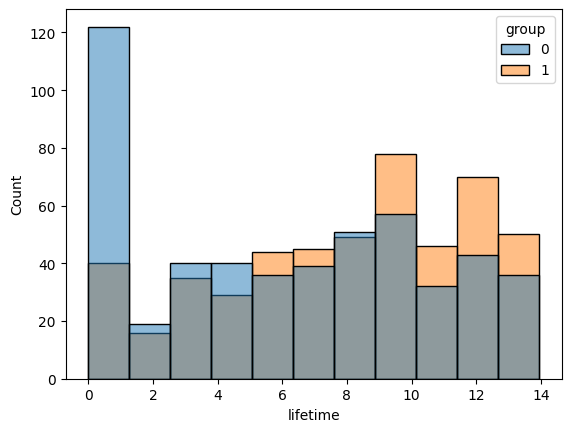

In [43]:
sns.histplot(data=retention, x="lifetime", hue="group")

In [44]:
pg.ttest(x=retention.query("group==0")["lifetime"], 
         y=retention.query("group==1")["lifetime"])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-7.079732,1004.533039,two-sided,2.710044e-12,"[-2.37, -1.34]",0.443316,2.188e+09,1.0


In [45]:
pg.mwu(x=retention.query("group==0")["lifetime"], 
       y=retention.query("group==1")["lifetime"])

,U-val,alternative,p-val,RBC,CLES
MWU,98354.0,two-sided,3.984586e-11,0.239129,0.380436


In [46]:
pd.crosstab(retention.group, retention.churn)

churn,0,1
group,,
0,252,263
1,332,170


In [47]:
exp, obs, stat = pg.chi2_independence(data=retention, x="group", y="churn")
stat

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,30.072727,1.0,4.161428e-08,0.171959,0.999787
1,cressie-read,0.666667,30.113482,1.0,4.074885e-08,0.172076,0.999790
2,log-likelihood,0.000000,30.250438,1.0,3.797055e-08,0.172467,0.999800
3,freeman-tukey,-0.500000,30.402505,1.0,3.510745e-08,0.172900,0.999810
4,mod-log-likelihood,-1.000000,30.597845,1.0,3.174461e-08,0.173454,0.999823
5,neyman,-2.000000,31.122750,1.0,2.422158e-08,0.174936,0.999852


## Анализ выживаемости

Анализ выживаемости позволяет анализировать время до того, как случится (или не случится) событие

In [48]:
kmf = lf.KaplanMeierFitter() #создаем модель

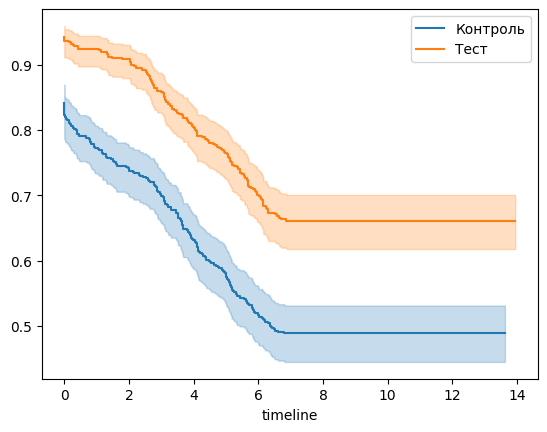

In [49]:
ax = plt.subplot(111) #чтобы поместить кривые групп на один рисунок

kmf.fit(durations=retention.query("group==0").lifetime, 
        event_observed=retention.query("group==0").churn,
        label="Контроль") #строим модель
kmf.plot(ax=ax) #рисуем

kmf.fit(durations=retention.query("group==1").lifetime, 
        event_observed=retention.query("group==1").churn,
        label="Тест")
kmf.plot(ax=ax)

plt.show()

In [50]:
lf.statistics.logrank_test(durations_A=retention.query("group==0").lifetime, 
                           durations_B=retention.query("group==1").lifetime, 
                           event_observed_A=retention.query("group==0").churn,
                           event_observed_B=retention.query("group==1").churn)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          37.41 <0.005     29.96

__Retention статистически значимо отличается в контрольной и тестовой группе__ (в пользу тестовой группы)

## Вывод: Вводим изменения в работу онлайн магазина